In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE

In [2]:
rainfall = pd.read_csv('Rainfall.csv')
rainfall['is_rainy_season'].value_counts()
rainfall['version'].value_counts()

,count
version,
final,24165
prelim,60
forecast,15


In [3]:
rainfall.rename(columns={'Unnamed: 0':'ID'})

,ID,date,adm_level,adm_id,PCODE,Name,Municipality,n_pixels,rfh,rfh_avg,...,dekad_of_month,is_rainy_season,sin_month,cos_month,drought_flag,high_rainfall_flag,r3h_6m_ma,r3h_12m_ma,rfh_3d_std,rfh_rate_change
0,203616,1981-01-01,2,1009451,GH0705,Ada East,Greater Accra,7.0,2.857143,3.504762,...,1,0,0.500000,0.866025,0,0,208.147033,208.147033,0.000000,2.857143
1,203617,1981-01-11,2,1009451,GH0705,Ada East,Greater Accra,7.0,2.285714,2.633333,...,2,0,0.500000,0.866025,0,0,208.147033,208.147033,0.404061,-0.571429
2,203618,1981-01-21,2,1009451,GH0705,Ada East,Greater Accra,7.0,6.000000,5.171429,...,3,0,0.500000,0.866025,0,1,208.147033,208.147033,2.000000,3.714286
3,203619,1981-02-01,2,1009451,GH0705,Ada East,Greater Accra,7.0,2.571429,3.576191,...,1,0,0.866025,0.500000,0,0,208.147033,208.147033,2.066908,-3.428571
4,203620,1981-02-11,2,1009451,GH0705,Ada East,Greater Accra,7.0,7.285714,7.752381,...,2,0,0.866025,0.500000,0,0,208.147033,208.147033,2.436960,4.714285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24235,357131,2025-10-01,2,1009545,GH0728,Tema West Municipal,Greater Accra,4.0,57.500000,28.366667,...,1,1,-0.866025,0.500000,0,1,282.500000,204.166667,12.273786,19.750000
24236,357132,2025-10-11,2,1009545,GH0728,Tema West Municipal,Greater Accra,4.0,61.000000,33.058334,...,2,1,-0.866025,0.500000,0,1,286.861111,206.743056,12.535782,3.500000
24237,357133,2025-10-21,2,1009545,GH0728,Tema West Municipal,Greater Accra,4.0,23.000000,30.616667,...,3,1,-0.866025,0.500000,0,0,288.708333,209.013889,21.001984,-38.000000
24238,357134,2025-11-01,2,1009545,GH0728,Tema West Municipal,Greater Accra,4.0,26.250000,12.725000,...,1,0,-0.500000,0.866025,0,1,289.888889,211.201389,21.063891,3.250000


In [4]:
rainfall.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24240 entries, 0 to 24239
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          24240 non-null  int64  
 1   date                24240 non-null  object 
 2   adm_level           24240 non-null  int64  
 3   adm_id              24240 non-null  int64  
 4   PCODE               24240 non-null  object 
 5   Name                24240 non-null  object 
 6   Municipality        24240 non-null  object 
 7   n_pixels            24240 non-null  float64
 8   rfh                 24240 non-null  float64
 9   rfh_avg             24240 non-null  float64
 10  r1h                 24240 non-null  float64
 11  r1h_avg             24240 non-null  float64
 12  r3h                 24240 non-null  float64
 13  r3h_avg             24240 non-null  float64
 14  rfq                 24240 non-null  float64
 15  r1q                 24240 non-null  float64
 16  r3q 

In [5]:
rainfall['high_rainfall_flag'].value_counts()

,count
high_rainfall_flag,
0,14377
1,9863


In [6]:
ids_to_drop = [
    "Unnamed: 0", "date", "adm_level", "adm_id", "PCODE",
    "Name", "Municipality", "version", "n_pixels"
]

# 2. Data Leakage (Current Rainfall measurements)
leakage_to_drop = [
    "rfh", "rfh_avg",
    "r1h", "r1h_avg",
    "r3h", "r3h_avg",
    "rfq", "r1q", "r3q",
    "rfh_3d_std", "drought_flag",
    "rfh_rate_change"
]

In [7]:
all_drop_cols = ids_to_drop + leakage_to_drop

In [8]:
X = rainfall.drop(columns=all_drop_cols + ["high_rainfall_flag"])
y = rainfall["high_rainfall_flag"]

In [9]:
# Split data into two halves (first half for training/testing, second half holdout)

X_first_half, X_second_half, y_first_half, y_second_half = train_test_split(
    X, y, test_size=0.5, random_state=42, stratify=y
)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X_first_half, y_first_half, test_size=0.3, random_state=42, stratify=y_first_half
)


In [11]:
smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


In [12]:
print("After SMOTE - training set class distribution:")
print(pd.Series(y_train_smote).value_counts(normalize=True).round(4))
print(f"New training samples: {len(y_train_smote)}\n")

After SMOTE - training set class distribution:
high_rainfall_flag
1    0.5
0    0.5
Name: proportion, dtype: float64
New training samples: 10064



In [13]:
# Training XGBoost on the SMOTE-resampled training set
model = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
model.fit(X_train_smote, y_train_smote)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [10:36:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [14]:
# Evaluate on first half's test set (not SMOTE'd)
y_pred_test = model.predict(X_test)
print("Classification Report on First Half Test Set:")
print(classification_report(y_test, y_pred_test))


Classification Report on First Half Test Set:
              precision    recall  f1-score   support

           0       0.70      0.67      0.68      2156
           1       0.55      0.59      0.57      1480

    accuracy                           0.64      3636
   macro avg       0.63      0.63      0.63      3636
weighted avg       0.64      0.64      0.64      3636



In [15]:
# Evaluate on untouched second half (holdout)
y_pred_holdout = model.predict(X_second_half)
print("Classification Report on Holdout Set:")
print(classification_report(y_second_half, y_pred_holdout))

Classification Report on Holdout Set:
              precision    recall  f1-score   support

           0       0.69      0.67      0.68      7189
           1       0.54      0.57      0.55      4931

    accuracy                           0.63     12120
   macro avg       0.62      0.62      0.62     12120
weighted avg       0.63      0.63      0.63     12120



In [16]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

# 1️⃣ Metrics on First Half Test Set
y_pred_test = model.predict(X_test)
y_pred_test_proba = model.predict_proba(X_test)[:, 1]  # probability for positive class

print("=== Results on First Half Test Set ===")
print(classification_report(y_test, y_pred_test, digits=4))
print(f"ROC-AUC:  {roc_auc_score(y_test, y_pred_test_proba):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))
print("\n" + "="*50 + "\n")

# 2️⃣ Metrics on Holdout Second Half
y_pred_holdout = model.predict(X_second_half)
y_pred_holdout_proba = model.predict_proba(X_second_half)[:, 1]

print("=== Results on Holdout Set ===")
print(classification_report(y_second_half, y_pred_holdout, digits=4))
print(f"ROC-AUC:  {roc_auc_score(y_second_half, y_pred_holdout_proba):.4f}")
print(f"Accuracy: {accuracy_score(y_second_half, y_pred_holdout):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_second_half, y_pred_holdout))


=== Results on First Half Test Set ===
              precision    recall  f1-score   support

           0     0.7039    0.6660    0.6845      2156
           1     0.5489    0.5919    0.5696      1480

    accuracy                         0.6359      3636
   macro avg     0.6264    0.6290    0.6270      3636
weighted avg     0.6408    0.6359    0.6377      3636

ROC-AUC:  0.6810
Accuracy: 0.6359
Confusion Matrix:
[[1436  720]
 [ 604  876]]


=== Results on Holdout Set ===
              precision    recall  f1-score   support

           0     0.6926    0.6681    0.6801      7189
           1     0.5398    0.5676    0.5534      4931

    accuracy                         0.6272     12120
   macro avg     0.6162    0.6179    0.6167     12120
weighted avg     0.6304    0.6272    0.6286     12120

ROC-AUC:  0.6735
Accuracy: 0.6272
Confusion Matrix:
[[4803 2386]
 [2132 2799]]


In [17]:
from sklearn.model_selection import GridSearchCV, train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier

# 1. Re-split the clean X and y (Just to be safe!)
X_first_half, X_second_half, y_first_half, y_second_half = train_test_split(
    X, y, test_size=0.5, random_state=42, stratify=y
)
X_train, X_test, y_train, y_test = train_test_split(
    X_first_half, y_first_half, test_size=0.3, random_state=42, stratify=y_first_half
)

# 2. Re-apply SMOTE to the training set
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# 3. Define the "Hyperparameter Grid" (The settings we want to test)
param_grid = {
    'n_estimators': [100, 200, 300],      # Number of trees
    'max_depth': [3, 5, 7],               # How deep each tree can go (lower = less overfitting)
    'learning_rate': [0.01, 0.1, 0.2],    # How fast the model learns
    'subsample': [0.8, 1.0]               # Fraction of data used per tree
}

# 4. Set up the Search
print("Starting Grid Search... (This might take a minute or two)")
grid_search = GridSearchCV(
    estimator=XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    param_grid=param_grid,
    cv=3,               # 3-fold cross-validation (internal testing)
    scoring='accuracy', # We want to maximize Accuracy
    n_jobs=-1,          # Use all computer cores to go faster
    verbose=1
)

# 5. Run the search on the training data
grid_search.fit(X_train_smote, y_train_smote)

# 6. Get the winner!
best_model = grid_search.best_estimator_
print(f"\nBest Parameters found: {grid_search.best_params_}")

# 7. Evaluate the Tuned Model on the Test Set
y_pred_tuned = best_model.predict(X_test)
new_accuracy = accuracy_score(y_test, y_pred_tuned)

print("\n=== Tuned Model Results ===")
print(f"New Accuracy: {new_accuracy:.4f}")
print(classification_report(y_test, y_pred_tuned))

Starting Grid Search... (This might take a minute or two)
Fitting 3 folds for each of 54 candidates, totalling 162 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [10:37:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Best Parameters found: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}

=== Tuned Model Results ===
New Accuracy: 0.6986
              precision    recall  f1-score   support

           0       0.74      0.76      0.75      2156
           1       0.64      0.61      0.62      1480

    accuracy                           0.70      3636
   macro avg       0.69      0.68      0.69      3636
weighted avg       0.70      0.70      0.70      3636



/tmp/ipython-input-1902498287.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance.head(10), x='Importance', y='Feature', palette='viridis')


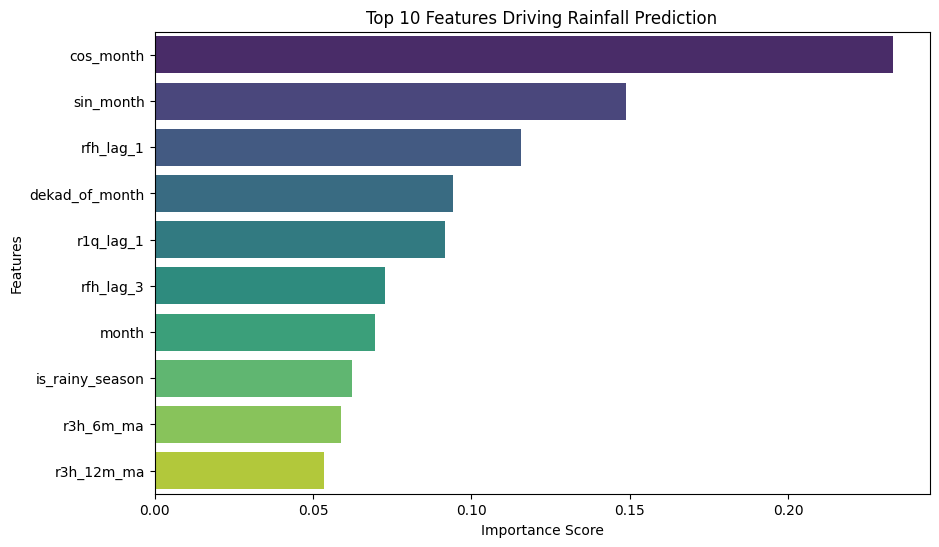

           Feature  Importance
7        cos_month    0.232907
6        sin_month    0.148650
0        rfh_lag_1    0.115687
4   dekad_of_month    0.094247
2        r1q_lag_1    0.091543
1        rfh_lag_3    0.072655
3            month    0.069524
5  is_rainy_season    0.062428
8        r3h_6m_ma    0.058808
9       r3h_12m_ma    0.053550


In [18]:
# Get feature importance
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot top 10 features
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(10), x='Importance', y='Feature', palette='viridis')
plt.title('Top 10 Features Driving Rainfall Prediction')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

print(feature_importance.head(10))

/tmp/ipython-input-3791730278.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance.head(10), x='Importance', y='Feature', palette='viridis')


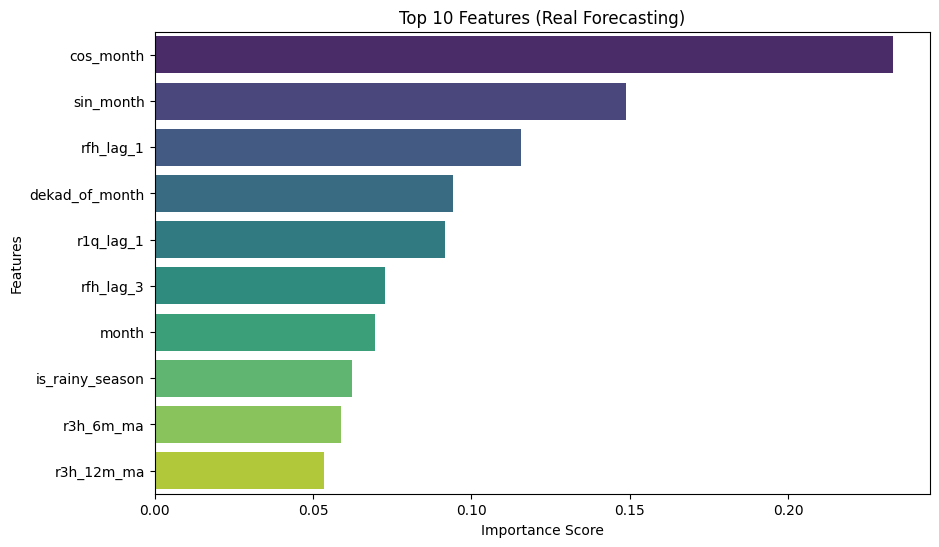

           Feature  Importance
7        cos_month    0.232907
6        sin_month    0.148650
0        rfh_lag_1    0.115687
4   dekad_of_month    0.094247
2        r1q_lag_1    0.091543
1        rfh_lag_3    0.072655
3            month    0.069524
5  is_rainy_season    0.062428
8        r3h_6m_ma    0.058808
9       r3h_12m_ma    0.053550


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importance from the trained model
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot top 10 features
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(10), x='Importance', y='Feature', palette='viridis')
plt.title('Top 10 Features (Real Forecasting)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

print(feature_importance.head(10))

=== FINAL HOLDOUT RESULTS ===
Holdout Accuracy: 0.6933

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.76      0.75      7189
           1       0.63      0.60      0.61      4931

    accuracy                           0.69     12120
   macro avg       0.68      0.68      0.68     12120
weighted avg       0.69      0.69      0.69     12120



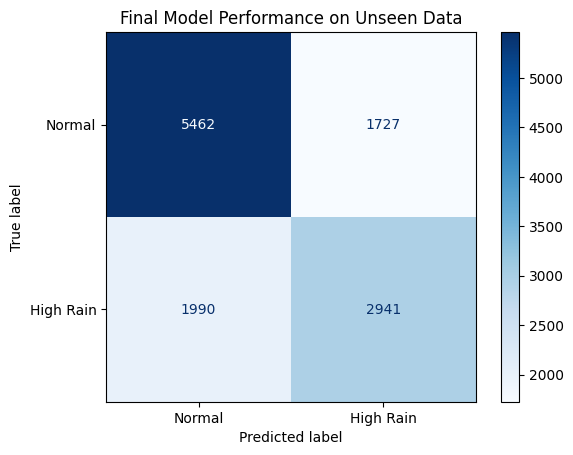

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Predict on the Holdout Set (The Second Half)
y_pred_holdout_tuned = best_model.predict(X_second_half)
holdout_accuracy = accuracy_score(y_second_half, y_pred_holdout_tuned)

print("=== FINAL HOLDOUT RESULTS ===")
print(f"Holdout Accuracy: {holdout_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_second_half, y_pred_holdout_tuned))

# 2. Visualize the Confusion Matrix (To see exactly where it makes mistakes)
cm = confusion_matrix(y_second_half, y_pred_holdout_tuned)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "High Rain"])
disp.plot(cmap='Blues')
plt.title("Final Model Performance on Unseen Data")
plt.show()